### Dataset

In [1]:
import os, random
import numpy as np
import timeit
import cv2, mahotas, skimage, skimage.feature, skimage.measure
from skimage.feature import local_binary_pattern
from mahotas.features.lbp import lbp, lbp_transform
import scipy.spatial.distance

from pathos.multiprocessing import ProcessingPool as Pool
pool = Pool(8).map

import matplotlib.pyplot as plt
%matplotlib inline

ImagePath = '/home/kampta/data/dtd/raw/images'

def pyplots(images, titles=None):
    num = len(images)
    plt.figure(figsize=(15,6))
    for index, im in enumerate(images):
        plt.subplot(2, num/2, index+1)
        plt.imshow(im)
        if titles is None:
            plt.title('%d'%(index))
        else:
            plt.title(str(titles[index]))
        plt.axis('off')
        
def kNN(srcVec, destVecs, k=7, method='CORREL', absolute=False):
    srcVec = srcVec.flatten().astype(np.float32)
    
    if method == 'CORREL':
        def dist(vec):
            return -cv2.compareHist(srcVec, vec.flatten().astype(np.float32), method=cv2.HISTCMP_CORREL)
    
    elif method == 'CHISQR':
        def dist(vec):
            return cv2.compareHist(srcVec, vec.flatten().astype(np.float32), method=cv2.HISTCMP_CHISQR)

    elif method == 'CHISQR_ALT':
        def dist(vec):
            return cv2.compareHist(srcVec, vec.flatten().astype(np.float32), method=cv2.HISTCMP_CHISQR_ALT)
        
    elif method == 'HELL':
        def dist(vec):
            return cv2.compareHist(srcVec, vec.flatten().astype(np.float32), method=cv2.HISTCMP_HELLINGER)
        
    elif method == 'KL':
        def dist(vec):
            return cv2.compareHist(srcVec, vec.flatten().astype(np.float32), method=cv2.HISTCMP_KL_DIV)
    
    elif method == 'EUC':
        def dist(vec):
            return scipy.spatial.distance.euclidean(srcVec, vec.flatten().astype(np.float32))
        
    pool = Pool(8).map
    distances = pool(dist, destVecs)
    
    if absolute:
        distances = np.absolute(distances)
        
    sortedIdx = np.argsort(distances)[:k]
        
    return sortedIdx, [distances[idx] for idx in sortedIdx]

In [2]:
titles = []
colImages = []
images = []

count = 0
for dirpath, dirname, filenames in os.walk(ImagePath):
    for filename in filenames:
        if filename.endswith('.jpg'):
            f = os.path.join(dirpath, filename)
            img = cv2.resize(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB), 
                             (128,128), 
                             interpolation = cv2.INTER_CUBIC)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            images.append(gray)
            colImages.append(img)
            titles.append(filename.split('_')[0])
            count+=1
            if count%1000 == 0:
                print "%d images read"%count
            
print "%d images read"%count

images = np.array(images)
colImages = np.array(colImages)
titles = np.array(titles)


1000 images read
2000 images read
3000 images read
4000 images read
5000 images read
5640 images read


## Sample Images

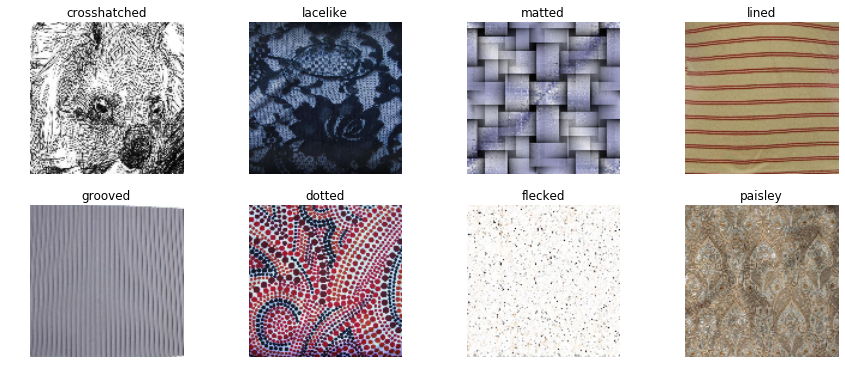

In [28]:
samples = random.sample(range(len(images)), 8)
pyplots(colImages[samples], titles[samples])

## Local Binary Patterns (from Mahotas)

### Correlation

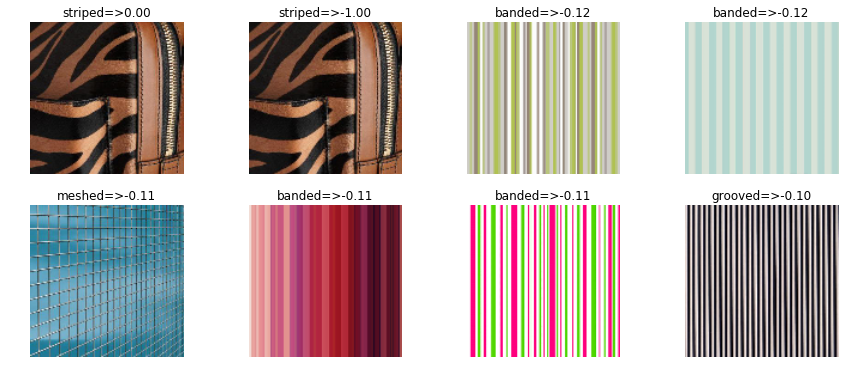

In [43]:
def transform(img):
    return lbp_transform(img, radius=2, points=16)

testIdx = 1495
test = transform(images[testIdx])


vectors = pool(transform, images)

nn, distances = kNN(test, vectors, method='CORREL')

plotIdx = [testIdx]+list(nn)
pyplots(colImages[plotIdx], titles=['%s=>%.2f'%(titles[idx], d) for idx,d in zip(plotIdx, [0] + list(distances))])

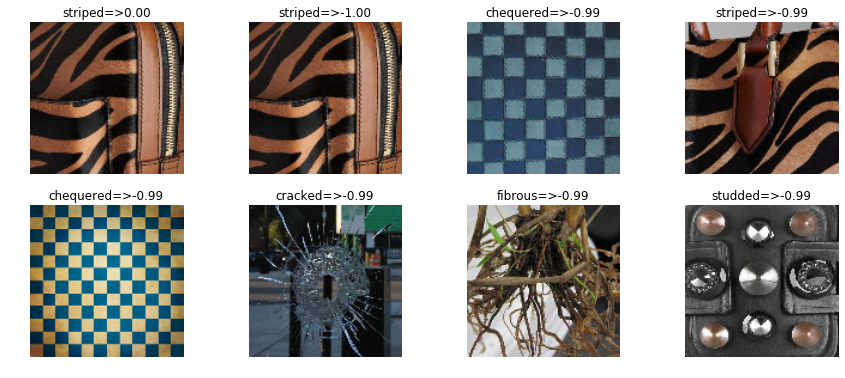

In [44]:
def transform(img):
    return mahotas.features.lbp(img, radius=2, points=16)

testIdx = 1495
test = transform(images[testIdx])

vectors = pool(transform, images)

nn, distances = kNN(test, vectors, method='CORREL')

plotIdx = [testIdx]+list(nn)
pyplots(colImages[plotIdx], titles=['%s=>%.2f'%(titles[idx], d) for idx,d in zip(plotIdx, [0] + list(distances))])

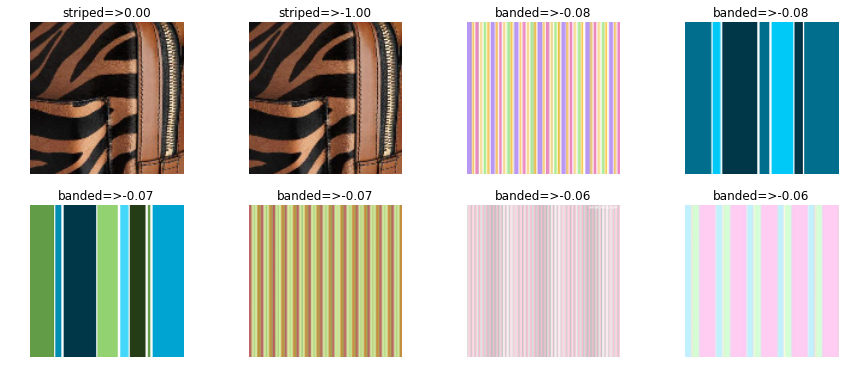

In [45]:
def transform(img):
    return local_binary_pattern(img, 16, 2, 'uniform')

testIdx = 1495
test = transform(images[testIdx])
vectors = pool(transform, images)

nn, distances = kNN(test, vectors, method='CORREL')

plotIdx = [testIdx]+list(nn)
pyplots(colImages[plotIdx], titles=['%s=>%.2f'%(titles[idx], d) for idx,d in zip(plotIdx, [0] + list(distances))])

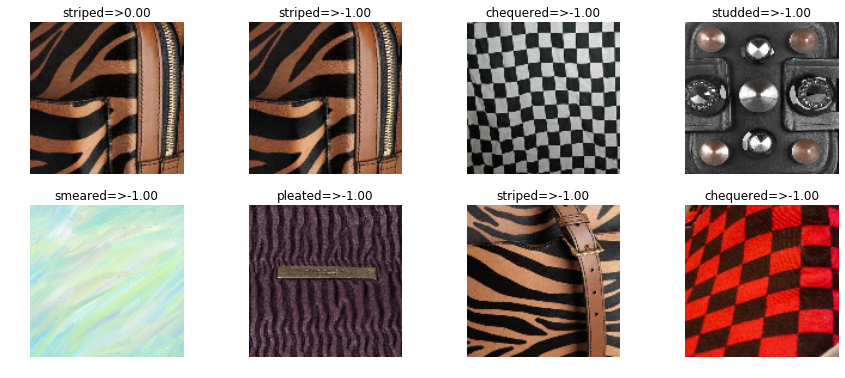

In [47]:
def transform(img):
    numPoints = 16
    radius = 2
    lbp = local_binary_pattern(img, numPoints, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
 
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 0.00001)
    return hist

testIdx = 1495
test = transform(images[testIdx])
vectors = pool(transform, images)

nn, distances = kNN(test, vectors, method='CORREL')

plotIdx = [testIdx]+list(nn)
pyplots(colImages[plotIdx], titles=['%s=>%.2f'%(titles[idx], d) for idx,d in zip(plotIdx, [0] + list(distances))])

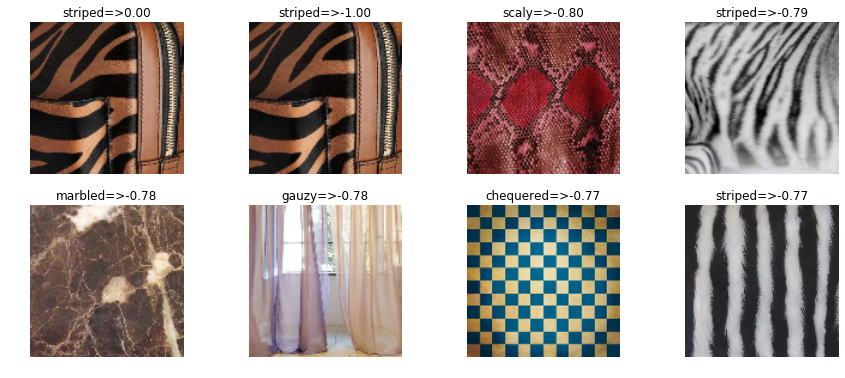

In [46]:
import scipy.io as sio
decaf = '/home/kampta/data/dtd/decaf/decaf_feats.mat'

vectors = sio.loadmat(decaf)['feats']

testIdx = 1495
test = matVectors[testIdx]

nn, distances = kNN(test, vectors, method='CORREL')

plotIdx = [testIdx]+list(nn)
pyplots(colImages[plotIdx], titles=['%s=>%.2f'%(titles[idx], d) for idx,d in zip(plotIdx, [0] + list(distances))])

## Other distance metrics

In [3]:
def transform(img):
    numPoints = 16
    radius = 2
    lbp = local_binary_pattern(img, numPoints, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
 
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 0.00001)
    return hist

testIdx = 1495
test = transform(images[testIdx])
vectors = pool(transform, images)


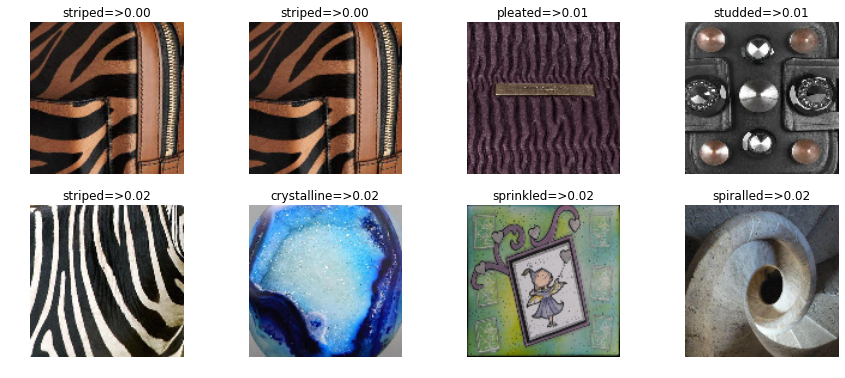

In [5]:
nn, distances = kNN(test, vectors, method='EUC')

plotIdx = [testIdx]+list(nn)
pyplots(colImages[plotIdx], titles=['%s=>%.2f'%(titles[idx], d) for idx,d in zip(plotIdx, [0] + list(distances))])